<a href="https://colab.research.google.com/github/R-hab/Reinforcement_learning/blob/main/Smart_taxiye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing Smart-Taxi Agent Using Reinforcement Learning

In [1]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install --upgrade AutoROM
# AutoROM --accept-license
!pip install gym[atari,accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.1.0-py3-none-any.whl size=3130 sha256=d7cffa70ab493bb48edbd12bfc77335f225f5cceda0429d0169ed8e4319e4026
  Stored in directory: /root/.cache/pip/wheels/34/dc/eb/4d1d8ef70b7d696391f62606424619637bf61d6bd43f7d2298
Successfully built colabgymrender
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=ecdd720a07b4352890682a2306b5a013c745e75fb353d910df8c82e8951569e4
  Stored in directory: /root/.cache/pip/wheels/b7/44/b7/2e7cc9c5fe4a893b9cc83a010d4410557bedf6cf3b5829f497
Successfully built imageio
  Attempting uninstall: imageio
    Found exist

In [3]:
!pip install gym[atari,accept-rom-license]==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [4]:
!pip install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Library

In [5]:
import gym
import numpy as np
import PIL.Image
import random
import tensorflow as tf
import logging
import imageio

from collections import namedtuple, deque
from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
from time import sleep

In [ ]:
env = gym.make("Taxi-v3")
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
state = env.reset()
state

414

In [ ]:
n_action_space = env.action_space.n
n_state_space = env.observation_space.n

In [ ]:
print("Number of Action Space:",n_action_space)
print("Number of State Space:",n_state_space)

Number of Action Space: 6
Number of State Space: 500


In [ ]:
state = env.reset()
state = env.encode(3, 3, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 368
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
# the dictionary indicate{action: [(probability, nextstate, reward, done)]}
env.P[368]

{0: [(1.0, 468, -1, False)],
 1: [(1.0, 268, -1, False)],
 2: [(1.0, 388, -1, False)],
 3: [(1.0, 368, -1, False)],
 4: [(1.0, 368, -10, False)],
 5: [(1.0, 368, -10, False)]}

In [ ]:
env.action_space.sample()

5

In [ ]:
Q = np.zeros((n_state_space,n_action_space))
Q

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

## Absolute Random movment

In [ ]:
state = env.reset()
epochs = 0
penalties, reward = 0, 0
frames = [] # for animation
done = False
while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    if reward == -10:
        penalties += 1
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward})
    epochs += 1 
print("Timesteps taken: {} Penalties incurred: {}".format(epochs,penalties))

Timesteps taken: 200 Penalties incurred: 72


In [ ]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)    
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Timestep: 200
State: 468
Action: 0
Reward: -1


In [ ]:
state = env.reset()

# Q-Learning

# Training the agent

In [ ]:
%%time
# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1
# For plotting metrics
all_epochs = []
all_penalties = []
framesss = []
rewards_per_episode = []
for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward,total_reward = 0, 0, 0,0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(Q[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = Q[state, action]
        next_max = np.max(Q[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        Q[state, action] = new_value

        if reward == -20:
            penalties += 1
            
            framesss.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward})
            
        total_reward += reward
        state = next_state
        epochs += 1
    rewards_per_episode.append(total_reward)

    if i % 100 == 0:
#         clear_output(wait=True)
#         print(f"Episode: {i},Total Reward: {total_reward}")
        print("Episode {} Total Reward: {}" .format(i,total_reward))

print("Training finished.\n")

Episode 100 Total Reward: 9
Episode 200 Total Reward: 7
Episode 300 Total Reward: -2
Episode 400 Total Reward: 8
Episode 500 Total Reward: 1
Episode 600 Total Reward: 14
Episode 700 Total Reward: -5
Episode 800 Total Reward: -23
Episode 900 Total Reward: 6
Episode 1000 Total Reward: 13
Episode 1100 Total Reward: 10
Episode 1200 Total Reward: 6
Episode 1300 Total Reward: 9
Episode 1400 Total Reward: 13
Episode 1500 Total Reward: 8
Episode 1600 Total Reward: -5
Episode 1700 Total Reward: 7
Episode 1800 Total Reward: 6
Episode 1900 Total Reward: 8
Episode 2000 Total Reward: 4
Episode 2100 Total Reward: 10
Episode 2200 Total Reward: -11
Episode 2300 Total Reward: -1
Episode 2400 Total Reward: -11
Episode 2500 Total Reward: 5
Episode 2600 Total Reward: -2
Episode 2700 Total Reward: 0
Episode 2800 Total Reward: -3
Episode 2900 Total Reward: 6
Episode 3000 Total Reward: 10
Episode 3100 Total Reward: -7
Episode 3200 Total Reward: 9
Episode 3300 Total Reward: 6
Episode 3400 Total Reward: 9
Epis

Episode 27500 Total Reward: 0
Episode 27600 Total Reward: 4
Episode 27700 Total Reward: -10
Episode 27800 Total Reward: -4
Episode 27900 Total Reward: 8
Episode 28000 Total Reward: 8
Episode 28100 Total Reward: 10
Episode 28200 Total Reward: -7
Episode 28300 Total Reward: -13
Episode 28400 Total Reward: 9
Episode 28500 Total Reward: -4
Episode 28600 Total Reward: 4
Episode 28700 Total Reward: 1
Episode 28800 Total Reward: -14
Episode 28900 Total Reward: 6
Episode 29000 Total Reward: 4
Episode 29100 Total Reward: -28
Episode 29200 Total Reward: 13
Episode 29300 Total Reward: 11
Episode 29400 Total Reward: 6
Episode 29500 Total Reward: 4
Episode 29600 Total Reward: 10
Episode 29700 Total Reward: 7
Episode 29800 Total Reward: -7
Episode 29900 Total Reward: 7
Episode 30000 Total Reward: 12
Episode 30100 Total Reward: 5
Episode 30200 Total Reward: 6
Episode 30300 Total Reward: 10
Episode 30400 Total Reward: 2
Episode 30500 Total Reward: 4
Episode 30600 Total Reward: 5
Episode 30700 Total Re

Episode 55000 Total Reward: 6
Episode 55100 Total Reward: 11
Episode 55200 Total Reward: -16
Episode 55300 Total Reward: 6
Episode 55400 Total Reward: 8
Episode 55500 Total Reward: -1
Episode 55600 Total Reward: 4
Episode 55700 Total Reward: -6
Episode 55800 Total Reward: 2
Episode 55900 Total Reward: 11
Episode 56000 Total Reward: 6
Episode 56100 Total Reward: 6
Episode 56200 Total Reward: -1
Episode 56300 Total Reward: 5
Episode 56400 Total Reward: 4
Episode 56500 Total Reward: 3
Episode 56600 Total Reward: -4
Episode 56700 Total Reward: -4
Episode 56800 Total Reward: 5
Episode 56900 Total Reward: 10
Episode 57000 Total Reward: 9
Episode 57100 Total Reward: 5
Episode 57200 Total Reward: 5
Episode 57300 Total Reward: -2
Episode 57400 Total Reward: -4
Episode 57500 Total Reward: 7
Episode 57600 Total Reward: -3
Episode 57700 Total Reward: -9
Episode 57800 Total Reward: 10
Episode 57900 Total Reward: 12
Episode 58000 Total Reward: 2
Episode 58100 Total Reward: 12
Episode 58200 Total Rew

Episode 82300 Total Reward: 11
Episode 82400 Total Reward: 4
Episode 82500 Total Reward: 13
Episode 82600 Total Reward: 5
Episode 82700 Total Reward: 6
Episode 82800 Total Reward: 7
Episode 82900 Total Reward: 8
Episode 83000 Total Reward: 4
Episode 83100 Total Reward: 3
Episode 83200 Total Reward: 9
Episode 83300 Total Reward: 10
Episode 83400 Total Reward: -5
Episode 83500 Total Reward: -4
Episode 83600 Total Reward: 7
Episode 83700 Total Reward: 4
Episode 83800 Total Reward: 10
Episode 83900 Total Reward: 6
Episode 84000 Total Reward: 4
Episode 84100 Total Reward: 7
Episode 84200 Total Reward: 7
Episode 84300 Total Reward: 3
Episode 84400 Total Reward: 10
Episode 84500 Total Reward: 5
Episode 84600 Total Reward: -9
Episode 84700 Total Reward: -2
Episode 84800 Total Reward: 0
Episode 84900 Total Reward: 9
Episode 85000 Total Reward: 8
Episode 85100 Total Reward: 1
Episode 85200 Total Reward: -5
Episode 85300 Total Reward: 8
Episode 85400 Total Reward: 10
Episode 85500 Total Reward: 5

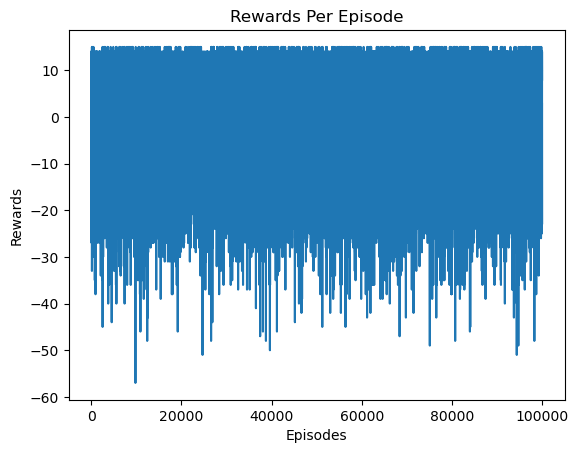

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, 100001), rewards_per_episode)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Rewards Per Episode')
plt.show()

In [ ]:
Q

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.41837066,  -2.3639511 ,  -2.41837066,  -2.3639511 ,
         -2.27325184, -11.3639511 ],
       [ -1.870144  ,  -1.45024   ,  -1.870144  ,  -1.45024   ,
         -0.7504    , -10.45024   ],
       ...,
       [ -1.1564324 ,   0.416     ,  -0.9935667 ,  -1.28903673,
         -6.0335514 ,  -5.66543616],
       [ -2.18071408,  -2.12208622,  -2.17012063,  -2.12208622,
         -6.64640967,  -6.60340502],
       [  3.01223681,   1.63644188,   4.27406111,  11.        ,
         -2.56330097,  -2.96167572]])

## Evaluate agent's performance

In [ ]:
total_epochs, total_penalties = 0, 0
episodes = 100000
penalties_per_episode = []
framess = []
for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False
    while not done:
        action = np.argmax(Q[state])
        state, reward, done, info = env.step(action)
        if reward == -20:
            penalties += 1
            framess.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward})
        epochs += 1
    total_penalties += penalties
    total_epochs += epochs
    penalties_per_episode.append(penalties)

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100000 episodes:
Average timesteps per episode: 13.07551
Average penalties per episode: 0.0


In [ ]:
# def print_frame(framess):
#     for i, frame in enumerate(framess):
#         clear_output(wait=True)
#         print(frame['frame'])
#         print(f"Timestep: {i + 1}")
#         print(f"State: {frame['state']}")
#         print(f"Action: {frame['action']}")
#         print(f"Reward: {frame['reward']}")
#         sleep(.1)    
# print_frame(framess)

In [ ]:
Q[368]

array([ -2.46758461,  -2.41837066,  -2.4675852 ,  -2.45056956,
       -10.95158908, -11.23077657])

# Visualiz best move

In [ ]:
state = env.reset()
done = None

In [ ]:
while done != True:
        action = np.argmax(Q[state])
        state, reward, done, info = env.step(action)
        env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y|

In [ ]:
import os,pickle
with open("smart_taxi_qtable.pkl", 'wb') as f:
    pickle.dump(Q,f)

In [ ]:
with open("smart_taxi_qtable.pkl", 'rb') as f:
    Qtest = pickle.load(f)

# Using Deep learning Model

In [6]:
Display(visible=False, size=(840, 480)).start()
tf.random.set_seed(0)

In [7]:
env = gym.make("Taxi-v3")
env.reset()

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


404

## Parametres

In [8]:
MEMORY_SIZE = 100_000
GAMMA = 0.95
ALPHA = 0.001
NUM_STEPS_FOR_UPDATE = 4

experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [9]:
num_states = env.observation_space.n
num_actions = env.action_space.n

# DQN

In [10]:
q_network = Sequential([
    Input(shape=num_states),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(num_actions, activation="linear")
])

target_q_network = Sequential([
    Input(shape=num_states),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(num_actions, activation="linear")
])

optimizer = Adam(learning_rate=ALPHA)

In [11]:
def compute_loss(experiences, gamma, q_network, target_q_network):
  states, actions, rewards, next_states, done_vals = experiences
  max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
  y_targets = rewards + (gamma * max_qsa * (1-done_vals))
  q_values = q_network(states)
  q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
  loss = MSE(y_targets, q_values)

  return loss

def update_target_network(q_network, target_q_network):
  TAU=1e-3
  for target_weights, q_network_weights in zip(target_q_network.weights, q_network.weights):
    target_weights.assign(TAU * q_network_weights + (1.0-TAU) * target_weights)

@tf.function
def agent_learn(experiences, gamma, q_network, target_q_network, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(experiences, gamma, q_network, target_q_network)
  gradients = tape.gradient(loss, q_network.trainable_variables)
  optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
  update_target_network(q_network, target_q_network)

def get_action(q_values, epsilon=0):
  if random.random() > epsilon:
    return np.argmax(q_values.numpy()[0])
  else:
    return random.choice(np.arange(6))

def check_update_conditions(j, NUM_STEPS_FOR_UPDATE, memory_buffer):
  if(j+1) % NUM_STEPS_FOR_UPDATE == 0 and len(memory_buffer) > 64:
    return True
  else:
    return False

def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=64)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

def get_new_epsilon(epsilon):
  E_MIN = 0.01
  E_DECAY = 0.05
  return max(E_MIN, E_DECAY * epsilon)

def get_one_hot_encoding(state, next_state):

  state_arr = np.zeros(500)
  next_state_arr = np.zeros(500)

  state_arr[state] = 1
  next_state_arr[next_state] = 1
  
  return state_arr, next_state_arr


from gym.envs.toy_text.frozen_lake import generate_random_map

def train():

  NUM_EPISODES = 50000
  MAX_TIMESTEPS = 1000

  memory_buffer = deque(maxlen=MEMORY_SIZE)
  target_q_network.set_weights(q_network.get_weights())

  epsilon = 1.0

  points_history = []

  for i in range(NUM_EPISODES):

    state = env.reset()
    state, _ = get_one_hot_encoding(state, 0)
    total_points = 0

    for j in range(MAX_TIMESTEPS):

      state_qn = np.expand_dims(state, axis=0)
      q_values = q_network(state_qn)
      action = get_action(q_values, epsilon)
      next_state, reward, done, _ = env.step(action)

      _, next_state = get_one_hot_encoding(0, next_state)

      memory_buffer.append(experience(state, action, reward, next_state, done))

      update = check_update_conditions(j, NUM_STEPS_FOR_UPDATE, memory_buffer)

      if update:
        experiences = get_experiences(memory_buffer)
        agent_learn(experiences, GAMMA, q_network, target_q_network, optimizer)

      state = next_state.copy()
      total_points += reward

      if done:
        break

    points_history.append(total_points)
    avg_points = np.mean(points_history[-100:])

    epsilon = get_new_epsilon(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {100} episodes: {avg_points:.2f}", end="")

    if (i+1) % 100 == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {100} episodes: {avg_points:.2f}")

    if(avg_points >= 8):
      print(f"Environment solved in {i+1} episodes!")
      q_network.save('taxiye_model.h5')
      break

train()

Episode 100 | Total point average of the last 100 episodes: -211.43
Episode 200 | Total point average of the last 100 episodes: -205.76
Episode 300 | Total point average of the last 100 episodes: -206.12
Episode 400 | Total point average of the last 100 episodes: -211.25
Episode 500 | Total point average of the last 100 episodes: -205.49
Episode 600 | Total point average of the last 100 episodes: -214.49
Episode 700 | Total point average of the last 100 episodes: -205.76
Episode 800 | Total point average of the last 100 episodes: -205.76
Episode 900 | Total point average of the last 100 episodes: -204.50
Episode 1000 | Total point average of the last 100 episodes: -206.30
Episode 1100 | Total point average of the last 100 episodes: -206.57
Episode 1200 | Total point average of the last 100 episodes: -205.76
Episode 1300 | Total point average of the last 100 episodes: -205.94
Episode 1400 | Total point average of the last 100 episodes: -208.91
Episode 1500 | Total point average of the l

Episode 8622 | Total point average of the last 100 episodes: 8.02Environment solved in 8622 episodes!


# Load saved Model

In [13]:
logging.getLogger().setLevel(logging.ERROR)
env = gym.make("Taxi-v3")
q_network = tf.keras.models.load_model('taxiye_model.h5')

# Testing the Model

In [14]:
def get_one_hot_encoding(state, next_state):

  state_arr = np.zeros(500)
  next_state_arr = np.zeros(500)

  state_arr[state] = 1
  next_state_arr[next_state] = 1
  
  return state_arr, next_state_arr

def create_video(filename, env, q_network, fps=30):
  video = imageio.get_writer(filename, fps=fps)
  done = False
  state = env.reset()
  frame = env.render(mode="rgb_array")
  video.append_data(frame)
  while not done:
    state, _ = get_one_hot_encoding(state, 0)
    state = np.expand_dims(state, axis=0)
    q_values = q_network(state)
    action = np.argmax(q_values.numpy()[0])
    state, _, done, _ = env.step(action)
    frame = env.render(mode="rgb_array")
    video.append_data(frame)
    for k in range(20):
      video.append_data(frame)

filename = "taxi.mp4"

create_video(filename, env, q_network)

/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.9/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


In [ ]:
# !pip install moviepy[optional]

In [15]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('taxi.mp4','rb').read()
data_url = "data:taxi/mp4;base64," + b64encode(mp4).decode()

In [16]:
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)